# Lesson 1: Introduction to Latent Semantic Analysis (LSA)

## Today's Focus
1. Understand why we need dimensionality reduction
2. Learn how LSA discovers hidden topics
3. Apply LSA to presidential speeches
4. Interpret what topics mean

## Next Class Preview
We'll dive deeper into:
- Choosing the optimal number of topics
- Understanding explained variance
- Comparing different dimensionality choices
- New application: News articles or product reviews

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

## Part 1: Load and Explore Our Data

Let's start by loading the presidential speeches dataset and understanding what we're working with. This dataset contains [State of the Unions speeches from US presidents](https://www.kaggle.com/datasets/rtatman/state-of-the-union-corpus-1989-2017), which should have distinct speaking styles and topics.

In [2]:
# Load the presidential speeches
df = pd.read_excel("presidential_speeches_updated.xlsx")

# Basic information about our dataset
print(f"Dataset Overview:")
print(f"- Total speeches: {len(df)}")
print(f"- Speakers: {df['speaker'].unique()}")
print(f"- Speeches per speaker:")
print(df['speaker'].value_counts())

Dataset Overview:
- Total speeches: 20
- Speakers: ['adams_1' 'adams_2' 'eisenhower' 'obama']
- Speeches per speaker:
speaker
eisenhower    8
adams_1       4
adams_2       4
obama         4
Name: count, dtype: int64


## Part 2: The Dimensionality Problem

When we convert text to TF-IDF, we get one dimension per word. With hundreds of words, this becomes unwieldy. Let's see why.

TF-IDF shape: (20, 7669)
That's 7669 dimensions to track!


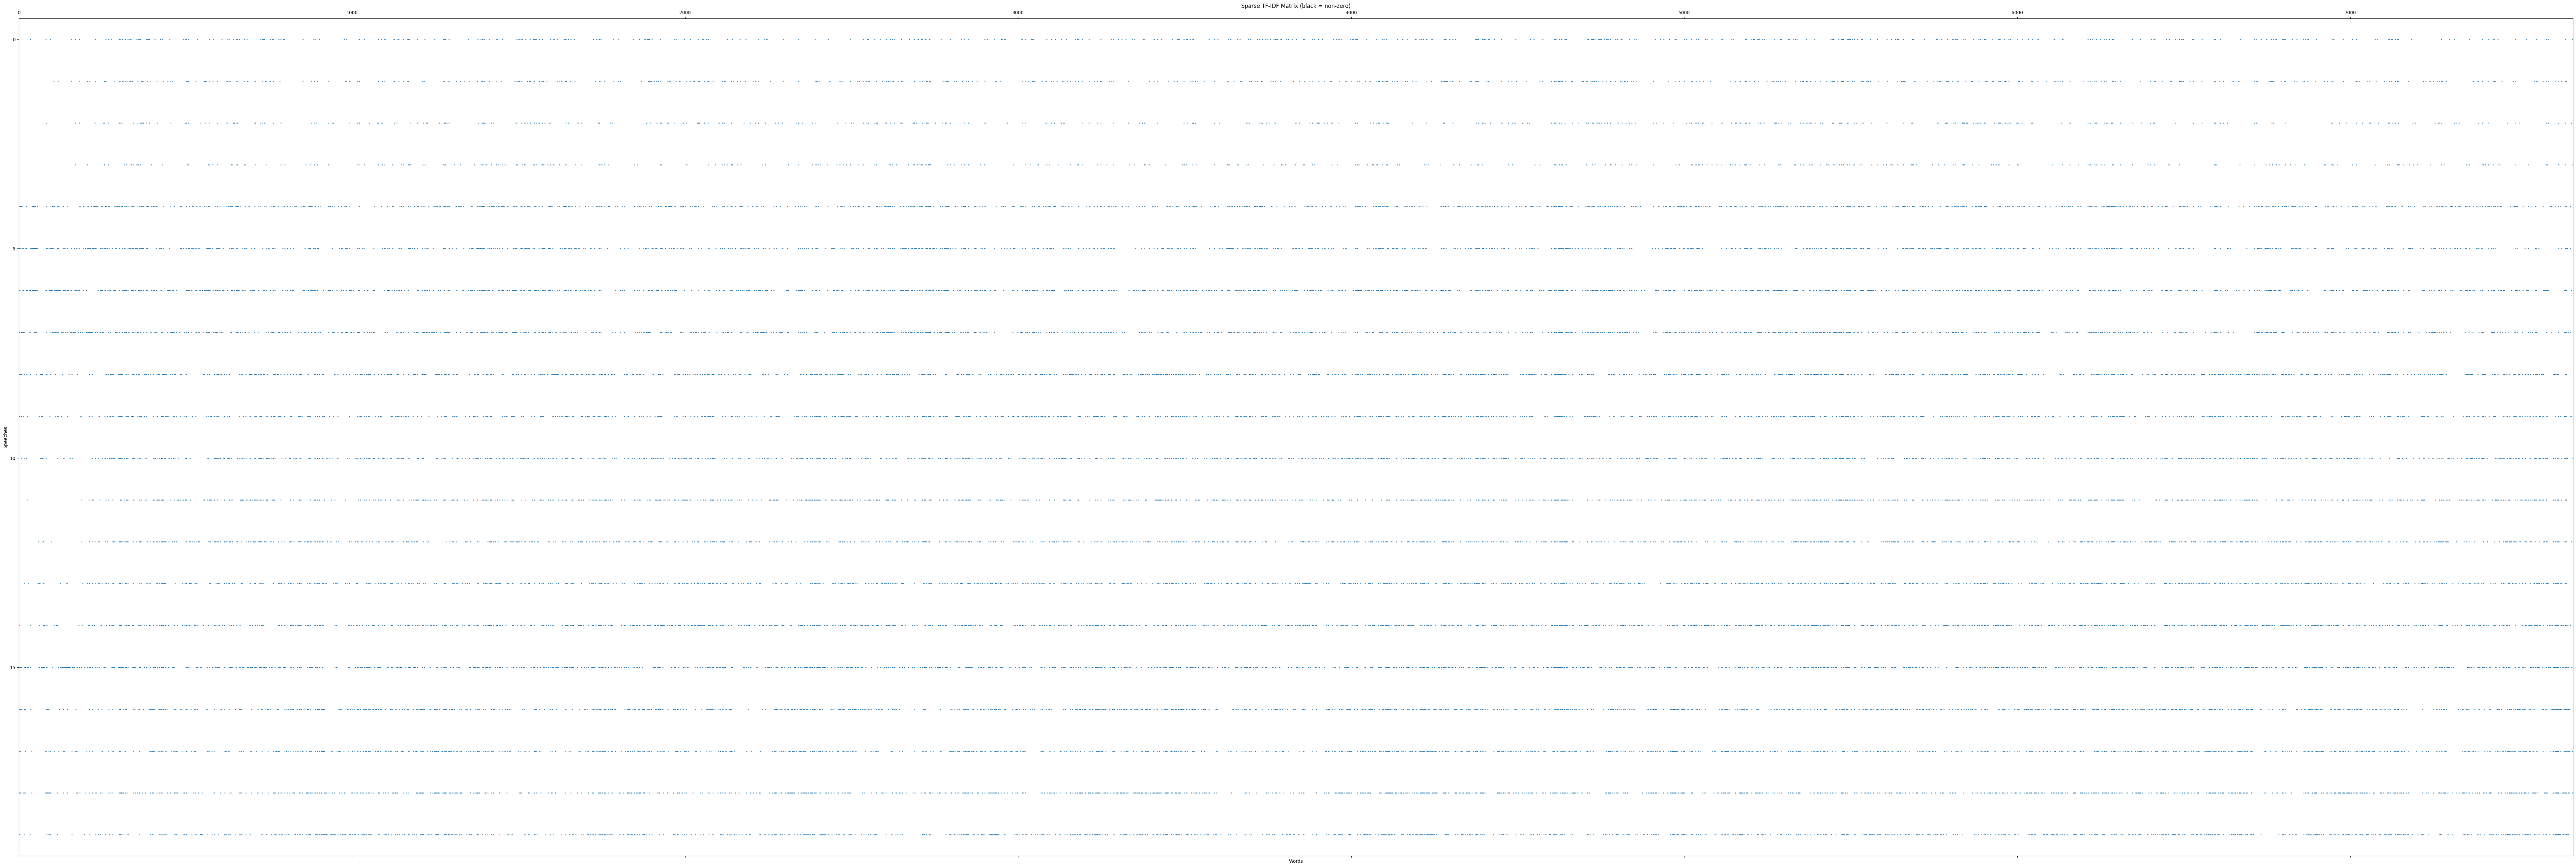


Matrix is 85.2% empty!


In [9]:
# Create TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')

X_tfidf = vectorizer.fit_transform(df['speech'])

print(f"TF-IDF shape: {X_tfidf.shape}")
print(f"That's {X_tfidf.shape[1]} dimensions to track!")

# Visualize sparsity
plt.figure(figsize=(100, 33))
plt.spy(X_tfidf.toarray(), markersize=1, aspect='auto')
plt.xlabel('Words')
plt.ylabel('Speeches')
plt.title('Sparse TF-IDF Matrix (black = non-zero)')
plt.show()

sparsity = 1.0 - (X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1]))
print(f"\nMatrix is {sparsity:.1%} empty!")

## Part 3: Apply LSA - Magic Dimensionality Reduction

LSA finds the "main themes" in our data. Instead of tracking thousands of individual words, we'll track just 4 topics.

In [18]:
# Apply LSA
n_topics = 4
lsa = TruncatedSVD(n_components = n_topics, random_state = 42)
X_topics = lsa.fit_transform(X_tfidf)

print(f"Before LSA: {X_tfidf.shape} (speeches × words)")
print(f"After LSA:  {X_topics.shape} (speeches × topics)")
print(f"{X_tfidf.shape[1]} dimensions → {n_topics}!")

# Quick peek at explained variance (we'll explore this more next class)
total_var = sum(lsa.explained_variance_ratio_)
print(f"\nThese {n_topics} topics capture {total_var:.1%} of the information")

Before LSA: (20, 7669) (speeches × words)
After LSA:  (20, 4) (speeches × topics)
7669 dimensions → 4!

These 4 topics capture 42.0% of the information


## Part 4: Visualize Speeches in 2D Space

Now let's see how our speeches cluster in the new topic space. Do speeches from the same speaker group together? This will tell us if LSA found meaningful patterns!

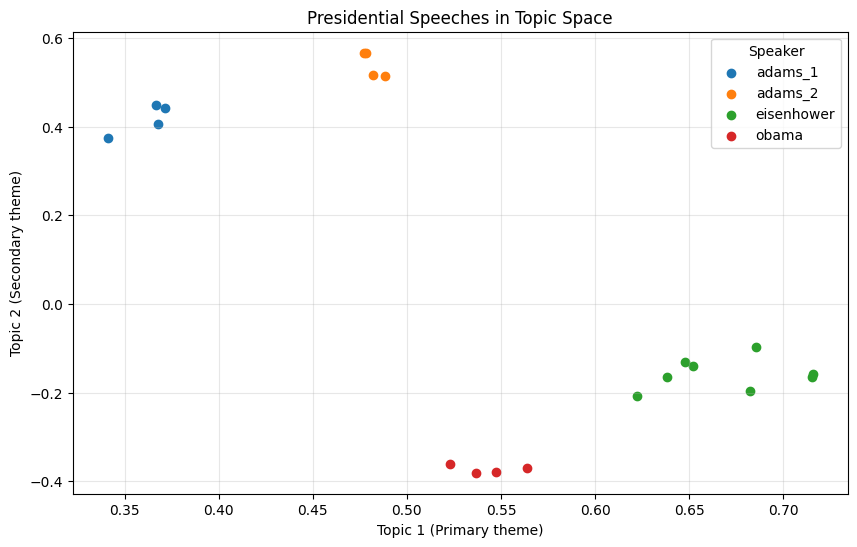

Notice how speeches from the same speaker tend to cluster together, even only using the first 2 dimensions!


In [22]:
# Create a dataframe with our results
lsa_df = pd.DataFrame(
    X_topics,
    columns=[f'Topic_{i+1}' for i in range(n_topics)]
)
lsa_df['Speaker'] = df['speaker'].values

# Visualize speeches in 2D topic space
plt.figure(figsize=(10, 6))

# Show latent space
for speaker in lsa_df['Speaker'].unique():
    mask = lsa_df['Speaker'] == speaker
    plt.scatter(lsa_df[mask]['Topic_1'],
                lsa_df[mask]['Topic_2'],
                label=speaker)

plt.xlabel('Topic 1 (Primary theme)')
plt.ylabel('Topic 2 (Secondary theme)')
plt.title('Presidential Speeches in Topic Space')
plt.legend(title='Speaker')
plt.grid(True, alpha=0.3)
plt.show()

print("Notice how speeches from the same speaker tend to cluster together, even only using the first 2 dimensions!")

## Part 5: What Do These Topics Mean?

Topics are combinations of words that tend to appear together. By looking at the top words in each topic, we can interpret what themes LSA discovered.

Remember: LSA discovers these topics automatically - we didn't tell it what to look for!

LSA creates a matrix called `components_` where:
- Each row is a topic
- Each column corresponds to a word in our vocabulary
- Values represent how strongly each word relates to that topic
- [See SVD documenation in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

We'll extract the most important words for each topic to interpret what themes LSA discovered.

In [20]:
# Get vocabulary
vocab = vectorizer.get_feature_names_out()

# Show top words per topic
print("Top 10 words for each topic:")
print("="*60)

# Loop through each topic
for topic_num in range(n_topics):
    # Get the words weighted per that topic
    topic = lsa.components_[topic_num]
    # Sort and grab the top 10 indices of the words weighted for that topic
    top_word_indices = np.argsort(topic)[::-1][:10]
    # Grab the associated words according to their index
    top_words = [vocab[i] for i in top_word_indices]

    # Print the resulting top 10 word per topic
    print(f"\nTopic {topic_num + 1}:")
    print(f"  {', '.join(top_words)}")

Top 10 words for each topic:

Topic 1:
  world, states, united, congress, new, year, 000, government, economic, people

Topic 2:
  000, states, united, gentlemen, commerce, duties, commissioners, treaty, vessels, intercourse

Topic 3:
  ve, jobs, tonight, let, america, job, americans, ll, 000, work

Topic 4:
  000, duties, colonies, convention, congress, act, condition, receipts, debt, year


## Part 6: Speaker Profiles

Which topics does each speaker prefer? This reveals their characteristic themes.

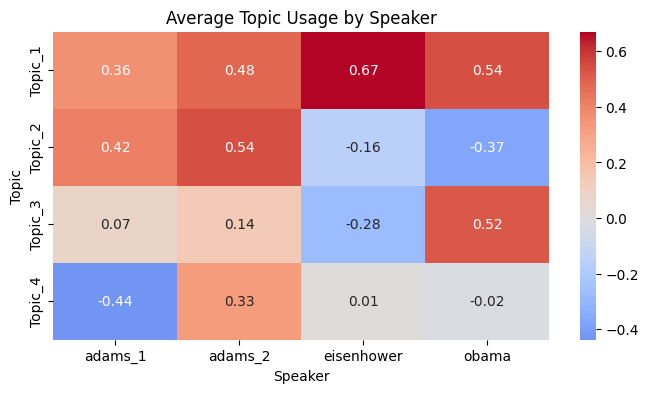

adams_1's dominant topic: Topic_2
adams_2's dominant topic: Topic_2
eisenhower's dominant topic: Topic_1
obama's dominant topic: Topic_1


In [14]:
# Average topic usage by speaker
speaker_profiles = lsa_df.groupby('Speaker').mean()

# Heatmap visualization
plt.figure(figsize=(8, 4))
sns.heatmap(speaker_profiles.T, annot=True, fmt='.2f',
            cmap='coolwarm', center=0)
plt.title('Average Topic Usage by Speaker')
plt.xlabel('Speaker')
plt.ylabel('Topic')
plt.show()

# Find each speaker's dominant topic
for speaker in speaker_profiles.index:
    dominant = speaker_profiles.loc[speaker].idxmax()
    print(f"{speaker}'s dominant topic: {dominant}")

## Part 7: Find Similar Speeches

LSA enables semantic search - finding documents similar in meaning, not just words.

In [15]:
# Test with a new text
test_text = ["The economy needs support. Jobs and healthcare are priorities."]

# Transform to topic space
test_tfidf = vectorizer.transform(test_text)
test_topics = lsa.transform(test_tfidf)

# Find similar speeches
similarities = cosine_similarity(test_topics, X_topics)[0]
top_matches = np.argsort(similarities)[::-1][:3]

print("Query text:", test_text[0])
print("\nMost similar speeches:")
for i, idx in enumerate(top_matches, 1):
    print(f"\n{i}. {df.iloc[idx]['speaker']} (similarity: {similarities[idx]:.2f})")
    print(f"   {df.iloc[idx]['speech'][:150]}...")

Query text: The economy needs support. Jobs and healthcare are priorities.

Most similar speeches:

1. obama (similarity: 0.99)
   Mr. Speaker, Mr. Vice President, Members of Congress, my
fellow Americans: We are 15 years into this new century. Fifteen years
that dawned with terro...

2. obama (similarity: 0.99)
   Mr. Speaker, Mr. Vice President, Members of Congress, my fellow
Americans:

Today in America, a teacher spent extra time with a student who needed
it,...

3. obama (similarity: 0.99)
   Mr. Speaker, Mr. Vice President, Members of Congress, my fellow
Americans:

Tonight marks the eighth year I've come here to report on the State of
the...


## Today's Key Takeaways

1. **LSA reduces dimensions** from hundreds of words to a handful of topics
2. **Topics emerge automatically** - we don't specify them
3. **Semantic similarity** works in topic space
4. **Different speakers** have different topic profiles

## Practice Exercise
Try changing `n_topics` to 3 or 10. What happens to:
- The speaker clusters?
- The topic interpretability?
- The similarity results?

## Next Class: Choosing the Right Number of Topics
We'll learn how to systematically choose the optimal number of topics using:
- Explained variance analysis
- Scree plots
- Cross-validation techniques